In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import pandas as pd
import numpy as np
import nltk.corpus
import nltk
%matplotlib inline

lower = False
feature = 'title'
#feature = 'tags'
#feature = 'description'
region, language = 'US', 'english'   # 
#region, language = 'KR', 'korean'    # doesn't work
#region, language = 'MX', 'spanish'   # doesn't work
#region, language = 'CA', 'english'   #
#region, language = 'DE', 'german'    #
#region, language = 'FR', 'french'    #

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

def load_region_data(region: str) -> pd.DataFrame:
    df = pd.read_csv('./archive/{}videos.csv'.format(region))

    # Drop unused columns
    df = df.drop(['thumbnail_link', 'video_id'], axis=1)
    df = df.dropna()

    # Enrich data
    df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
    df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
    df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
    df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
    df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: (row['likes'] / np.sum([row['likes'], row['dislikes']]))*100, axis=1)
    df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
    df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)

    # Transform category_id to label
    category_le = sk.preprocessing.LabelEncoder()
    category_le.fit(df['category_id'])
    df['category_id'] = category_le.transform(df['category_id'])
    
    views = df['views'].to_numpy().reshape((-1,1))
    view_scaler = sk.preprocessing.StandardScaler()
    df['views'] = view_scaler.fit_transform(views)*100
    
    df = df.dropna()
    
    # Load stopwords
    try:
        stop_words = set(nltk.corpus.stopwords.words(language))
    except Exception:
        nltk.download('stopwords')
        stop_words = set(nltk.corpus.stopwords.words(language))
    
    # Drop stopwords
    df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
    
    return df, len(category_le.classes_)

df, num_classes = load_region_data(region)
df.head()

Num GPUs Available:  1


<ipython-input-1-6588991862af>:35: RuntimeWarning: invalid value encountered in long_scalars
  df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: (row['likes'] / np.sum([row['likes'], row['dislikes']]))*100, axis=1)


,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_hour,like_dislike,anti_participation
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,7,2017-11-13T17:13:01.000Z,SHANtell martin,-21.841306,57527,2966,15954,0,0,0,SHANTELL'S CHANNEL - https://www.youtube.com/s...,17,95.096953,0
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,9,2017-11-13T07:30:00.000Z,last week tonight trump presidency last week t...,0.645417,97185,6146,12703,0,0,0,"One year presidential election, John Oliver di...",7,94.052124,0
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,8,2017-11-12T19:05:24.000Z,racist superman rudy mancuso king bach racist ...,11.046695,146033,5339,8181,0,0,0,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,19,96.472928,0
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,9,2017-11-13T11:00:04.000Z,rhett link gmm good mythical morning rhett lin...,-27.296111,10172,666,2146,0,0,0,Today find Link Nickelback amateur secret Nick...,11,93.854955,0
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,9,2017-11-12T18:01:41.000Z,ryan higa higatv nigahiga dare idy rhpc dares ...,-3.703447,132235,1989,17518,0,0,0,"I know since show, we're back might best episo...",18,98.518149,0


In [2]:
def convert_to_sequences(x):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=lower)
    tokenizer.fit_on_texts(x)
    _sequences = tokenizer.texts_to_sequences(x)
    maxlen = max(len(_seq) for _seq in _sequences)
    vocab_size = len(tokenizer.word_index) + 1
    _xtr = tf.keras.preprocessing.sequence.pad_sequences(_sequences, maxlen, padding='post')
    
    return np.array(_xtr), maxlen, vocab_size

if feature == 'tags':
    X, maxlen, vocab_size = convert_to_sequences(df['tags'].to_numpy())
elif feature == 'description':
    X, maxlen, vocab_size = convert_to_sequences(df['description'].to_numpy())
elif feature == 'title': 
    X, maxlen, vocab_size = convert_to_sequences(df['title'].to_numpy())

Y = df['views'].to_numpy().reshape((-1,1))

X.shape, Y.shape

((40209, 20), (40209, 1))

In [5]:
activation = 'relu'

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(maxlen,)))
model.add(tf.keras.layers.Embedding(vocab_size, 75))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation=activation))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(8))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation=activation))

model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=['mse']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 75)            1030275   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 75)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 13, 64)            38464     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 8, 32)             12320     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 16)             2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 16)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 5, 8)             

In [6]:
# Initialize history variables
loss_history, mse_history = [[],[]], [[],[]]
final_accuracy = -1.

# Kfold cross validation
skf = sk.model_selection.KFold(n_splits=10, shuffle=True)
for train_index, val_index in skf.split(X, Y):
    # Get train and test fold
    xtrain, xval = X[train_index], X[val_index]
    
    # We need to convert the Y to a categorical type in order for the 
    # multi-classifier to train and validate properly
    ytrain, yval = Y[train_index], Y[val_index]
    
    # Train and validate
    history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=3, batch_size=64)
    
    # Add values to training history
    loss_history[0].extend(history.history['val_loss'])
    loss_history[1].extend(history.history['loss'])
    mse_history[0].extend(history.history['val_mse'])
    mse_history[1].extend(history.history['mse'])

Epoch 1/3
566/566 [==============================] - 3s 5ms/step - loss: 8206.3311 - mse: 8206.3311 - val_loss: 8085.7964 - val_mse: 8085.7964
Epoch 2/3
566/566 [==============================] - 3s 5ms/step - loss: 4731.3936 - mse: 4731.3936 - val_loss: 6438.3730 - val_mse: 6438.3730
Epoch 3/3
566/566 [==============================] - 3s 5ms/step - loss: 3700.9363 - mse: 3700.9363 - val_loss: 5367.5112 - val_mse: 5367.5112
Epoch 1/3
566/566 [==============================] - 3s 5ms/step - loss: 3533.9768 - mse: 3533.9768 - val_loss: 3578.1021 - val_mse: 3578.1021
Epoch 2/3
566/566 [==============================] - 3s 5ms/step - loss: 3276.4153 - mse: 3276.4153 - val_loss: 2654.7029 - val_mse: 2654.7029
Epoch 3/3
566/566 [==============================] - 3s 5ms/step - loss: 3198.1343 - mse: 3198.1343 - val_loss: 2808.6743 - val_mse: 2808.6743
Epoch 1/3
566/566 [==============================] - 3s 5ms/step - loss: 2994.6743 - mse: 2994.6743 - val_loss: 2033.0569 - val_mse: 2033.0569

In [ ]:
history.history

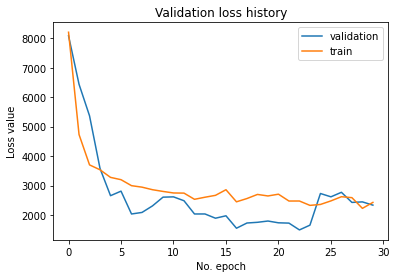

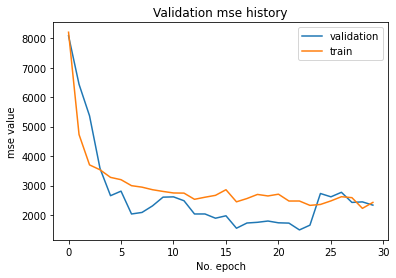

In [7]:
# Visualize history
# Plot history: Loss
fig, ax = plt.subplots()
ax.plot(loss_history[0], label='validation')
ax.plot(loss_history[1], label='train')
ax.set(title='Validation loss history', xlabel='No. epoch', ylabel='Loss value')
ax.legend()


# Plot history: Accuracy
fig, ax = plt.subplots()
ax.plot(mse_history[0], label='validation')
ax.plot(mse_history[1], label='train')
ax.set(title='Validation mse history', xlabel='No. epoch', ylabel='mse value')
ax.legend()

plt.show()

In [ ]:
import os
os.makedirs('.models/', exist_ok=True)

# Save model
model.save('.models/model-{region}-{feature}-{accuracy:.2f}.h5'.format(region=region, feature=feature, accuracy=final_accuracy))